##Installs

In [20]:
# Install system dependency for cfgrib
!apt-get update && apt-get install -y libeccodes-dev

# Install Python packages
!pip install xarray cfgrib aiohttp aiofiles tqdm cartopy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 388 kB in 2s (180 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does

##ENS

In [16]:
#!/usr/bin/env python
# ============================================================
# ECMWF Open Data IFS ENS Downloader (Python/Asyncio Version)
# FIXED FOR GOOGLE COLAB - CORRECTED FILE HANDLING
# ============================================================

import asyncio
import aiohttp
import aiofiles
import json
import os
import sys
import time
import shutil
import multiprocessing
import xarray as xr
import cfgrib
from pathlib import Path
from glob import glob
from tqdm.asyncio import tqdm as async_tqdm
from tqdm import tqdm as sync_tqdm
from functools import partial

# FIXED for Google Colab: Allow nested event loops
try:
    import nest_asyncio
    nest_asyncio.apply()
except ImportError:
    pass

# --- Configuration ---
CLIP_BOX = {'lat_min': 20, 'lat_max': 27, 'lon_min': 88, 'lon_max': 93}

# ============================================================
# SET THESE VALUES FOR YOUR RUN
# ============================================================
DATE = "20251018"      # YYYYMMDD
TIME = "12z"           # 00z, 06z, 12z, 18z
VARIABLE = "2t"        # 2t, tp, msl, 10u, 10v, etc.
# ============================================================

async def download_index(session, step, index_dir, base_url, date, time_num):
    """Downloads a single index file."""
    filename = f"{date}{time_num}0000-{step}h-enfo-ef.index"
    url = f"{base_url}/{filename}"
    out_path = index_dir / filename

    if out_path.exists() and out_path.stat().st_size > 0:
        try:
            async with aiofiles.open(out_path, 'r') as f:
                first_line = await f.readline()
                if '"param"' in first_line:
                    return f"✅ Skipped {step}h (already exists)"
        except Exception:
            pass

    try:
        async with session.get(url) as response:
            response.raise_for_status()
            content = await response.text()

            if '"param"' not in content:
                return f"⚠️ Invalid (non-JSON) file for step {step}h"

            async with aiofiles.open(out_path, 'w') as f:
                await f.write(content)
            return f"✅ {step}h"
    except aiohttp.ClientError as e:
        return f"❌ Failed to download step {step}h: {str(e)}"

async def step1_download_all_indices(index_dir, base_url, date, time_num, steps):
    """(Replaces Bash Step 1)"""
    print(f"\n📥 [Step 1] Downloading all {len(steps)} index files...")
    tasks = []

    async with aiohttp.ClientSession() as session:
        for step in steps:
            tasks.append(download_index(session, step, index_dir, base_url, date, time_num))

        results = []
        for f in async_tqdm.as_completed(tasks, total=len(tasks), desc="Downloading Indices"):
            results.append(await f)

    print("✅ Index download complete!")

def step2_parse_indices_and_create_jobs(index_dir, var_dir, base_url, date, time_num, variable):
    """(Replaces Bash Step 2 & 3)"""
    print(f"\n🔍 [Step 2] Gathering {variable} records...")
    download_jobs = []

    index_files = list(index_dir.glob("*.index"))
    if not index_files:
        print("❌ No valid index files found. Aborting.")
        return []

    for index_file in index_files:
        grib_filename = index_file.name.replace('.index', '.grib2')
        grib_url = f"{base_url}/{grib_filename}"

        with open(index_file, 'r') as f:
            for line in f:
                if f'"param": "{variable}"' in line:
                    try:
                        record = json.loads(line)

                        ens_raw = record.get("number")
                        if ens_raw is None:
                            ens_raw = 0

                        ens = f"{int(ens_raw):02d}"
                        offset = int(record["_offset"])
                        length = int(record["_length"])
                        step_val = int(record["step"])

                        out_dir = var_dir / f"EN{ens}"
                        out_dir.mkdir(exist_ok=True)
                        out_path = out_dir / f"{variable}_{step_val}h.grib2"

                        download_jobs.append((grib_url, out_path, offset, length, ens, step_val))

                    except json.JSONDecodeError:
                        pass

    print(f"✅ Found {len(download_jobs)} {variable} records to download.")
    return download_jobs

async def download_grib_slice(session, job):
    """Downloads a single GRIB slice using byte-range request."""
    grib_url, out_path, offset, length, ens, step = job

    if out_path.exists() and out_path.stat().st_size == length:
        return (True, f"✅ Skipping EN{ens} step {step}h")

    end = offset + length - 1
    headers = {'Range': f'bytes={offset}-{end}'}

    try:
        async with session.get(grib_url, headers=headers) as response:
            response.raise_for_status()
            content = await response.read()
            async with aiofiles.open(out_path, 'wb') as f:
                await f.write(content)
            return (True, f"✅ EN{ens} step {step}h")
    except Exception as e:
        return (False, f"❌ Failed EN{ens} step {step}h: {str(e)[:50]}")

async def step3_download_all_gribs(download_jobs, variable):
    """(Replaces Bash Step 4)"""
    print(f"\n🚀 [Step 3] Extracting {variable} slices in parallel...")
    tasks = []

    timeout = aiohttp.ClientTimeout(total=300)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        for job in download_jobs:
            tasks.append(download_grib_slice(session, job))

        results = []
        failures = []
        for f in async_tqdm.as_completed(tasks, total=len(tasks), desc=f"Downloading {variable} GRIBs"):
            success, msg = await f
            results.append(msg)
            if not success:
                failures.append(msg)

    if failures:
        print(f"\n⚠️ Warning: {len(failures)} downloads failed:")
        for fail in failures[:10]:
            print(f"   {fail}")
        if len(failures) > 10:
            print(f"   ... and {len(failures) - 10} more failures")

    print(f"✅ All {variable} ensemble GRIBs extracted! ({len(results) - len(failures)}/{len(results)} successful)")
    return len(failures) == 0

def get_step_from_path(grib_file_path):
    """Helper to sort GRIB files numerically by step."""
    try:
        step_str = Path(grib_file_path).stem.split('_')[-1].replace('h', '')
        return int(step_str)
    except Exception:
        return -1

def process_ensemble_member(ens_num, var_dir, out_dir, date, time, variable, clip_box):
    """Merges, clips, and saves NetCDF for one ensemble member."""
    ens_str = f"{int(ens_num):02d}"
    ens_dir = var_dir / f"EN{ens_str}"
    out_file = out_dir / f"{date}_{time}_{variable}_EN{ens_str}.nc"
    temp_file = out_dir / f"{date}_{time}_{variable}_EN{ens_str}.nc.tmp"

    if out_file.exists() and out_file.stat().st_size > 1000:  # At least 1KB
        return f"✅ Skipping EN{ens_str} (already merged)"

    grib_files_unsorted = glob(str(ens_dir / f"*.grib2"))
    if not grib_files_unsorted:
        return f"⚠️ No GRIB files found for EN{ens_str}"

    grib_files = sorted(grib_files_unsorted, key=get_step_from_path)

    try:
        # Open each GRIB file individually with better error handling
        ds_list = []
        actual_var_name = None

        for grib_file in grib_files:
            try:
                ds = xr.open_dataset(
                    grib_file,
                    engine='cfgrib',
                    backend_kwargs={'indexpath': ''}  # Avoid index cache issues
                )

                # Find the actual variable name (GRIB may rename it)
                data_vars = [v for v in ds.data_vars if v not in ['latitude', 'longitude', 'time', 'step', 'valid_time']]
                if data_vars and actual_var_name is None:
                    actual_var_name = data_vars[0]

                ds_list.append(ds)
            except Exception as e:
                print(f"   ⚠️ EN{ens_str}: Could not read {Path(grib_file).name}: {str(e)[:40]}")
                continue

        if not ds_list:
            return f"❌ Could not read any GRIB files for EN{ens_str}"

        # Merge datasets along time/step dimension
        try:
            ds = xr.concat(ds_list, dim='step', coords='minimal', compat='override')
        except Exception as e:
            # Fallback: try concatenating along time dimension
            ds = xr.concat(ds_list, dim='time', coords='minimal', compat='override')

        # Clip to region
        try:
            # Determine coordinate names
            lat_name = 'latitude' if 'latitude' in ds.dims else ('lat' if 'lat' in ds.dims else None)
            lon_name = 'longitude' if 'longitude' in ds.dims else ('lon' if 'lon' in ds.dims else None)

            if lat_name and lon_name:
                ds_clipped = ds.sel(
                    {lat_name: slice(clip_box['lat_max'], clip_box['lat_min']),
                     lon_name: slice(clip_box['lon_min'], clip_box['lon_max'])}
                )
            else:
                print(f"   ⚠️ EN{ens_str}: Could not find lat/lon coordinates, saving full domain")
                ds_clipped = ds
        except Exception as e:
            print(f"   ⚠️ EN{ens_str}: Clipping failed ({str(e)[:30]}), saving full domain")
            ds_clipped = ds

        # Save to NetCDF with compression (use temp file to avoid corruption)
        if actual_var_name:
            encoding = {
                actual_var_name: {
                    'zlib': True,
                    'complevel': 4,
                    'dtype': 'float32'
                }
            }
        else:
            encoding = {}

        # Write to temp file first, then rename (atomic operation)
        ds_clipped.to_netcdf(temp_file, encoding=encoding, format='NETCDF4')

        # Move temp file to final location
        if temp_file.exists():
            if out_file.exists():
                out_file.unlink()  # Remove existing file
            temp_file.rename(out_file)

        # Close datasets to free memory
        for ds_item in ds_list:
            ds_item.close()
        ds_clipped.close()

        # Verify file was created with content
        if out_file.exists():
            file_size = out_file.stat().st_size
            if file_size > 1000:  # At least 1KB
                return f"✅ EN{ens_str} ({file_size / 1e6:.2f} MB)"
            else:
                return f"❌ EN{ens_str}: File created but empty ({file_size} bytes)"
        else:
            return f"❌ EN{ens_str}: File not created"

    except Exception as e:
        # Clean up temp file if it exists
        if temp_file.exists():
            try:
                temp_file.unlink()
            except:
                pass
        return f"❌ EN{ens_str}: {str(e)[:80]}"

def step4_process_all_ensembles(var_dir, out_dir, date, time, variable, clip_box):
    """(Replaces parallel part of Bash Step 5)"""
    print("\n🌀 [Step 4] Merging & clipping per ensemble (using multiprocessing)...")

    ensemble_numbers = range(0, 51)
    num_cores = min(os.cpu_count() or 4, 8)  # Limit to 8 cores max to avoid memory issues

    process_func = partial(
        process_ensemble_member,
        var_dir=var_dir,
        out_dir=out_dir,
        date=date,
        time=time,
        variable=variable,
        clip_box=clip_box
    )

    with multiprocessing.Pool(processes=num_cores) as pool:
        results = list(sync_tqdm(
            pool.imap(process_func, ensemble_numbers),
            total=len(ensemble_numbers),
            desc="Processing Ensembles"
        ))

    print("\n   Processing Results:")
    success_count = 0
    for res in sorted(results):
        if "✅" in res and "Skipping" not in res:
            success_count += 1
        if "❌" in res or "⚠️" in res:
            print(f"   {res}")

    print(f"\n   Successfully processed: {success_count}/51 ensembles")
    return success_count

def step5_cleanup(index_dir, var_dir):
    """Clean up temporary files"""
    print("\n🧹 [Step 5] Cleaning up temporary files...")
    try:
        shutil.rmtree(index_dir)
        shutil.rmtree(var_dir)
        print("✅ Cleanup complete.")
    except OSError as e:
        print(f"⚠️ Warning: Could not remove temp directories: {e}")

async def main():
    time_num = TIME.replace('z', '')
    steps = range(0, 361, 6)

    BASE_URL = f"https://storage.googleapis.com/ecmwf-open-data/{DATE}/{TIME}/ifs/0p25/enfo"

    MAIN_DIR = Path(f"data/ens/{DATE}_{TIME}_{VARIABLE}")
    INDEX_DIR = MAIN_DIR / "index_files"
    VAR_DIR = MAIN_DIR / "var_data"
    OUT_DIR = MAIN_DIR

    INDEX_DIR.mkdir(parents=True, exist_ok=True)
    VAR_DIR.mkdir(parents=True, exist_ok=True)
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    print("============================================================")
    print(f" ECMWF Open Data IFS ENS Downloader (Python Version)")
    print(f" DATE: {DATE} | TIME: {TIME} | VARIABLE: {VARIABLE}")
    print(f" Output Dir: {MAIN_DIR}")
    print("============================================================")

    start_time = time.time()

    await step1_download_all_indices(INDEX_DIR, BASE_URL, DATE, time_num, steps)

    download_jobs = step2_parse_indices_and_create_jobs(INDEX_DIR, VAR_DIR, BASE_URL, DATE, time_num, VARIABLE)
    if not download_jobs:
        print("❌ No download jobs found. Exiting.")
        return

    success = await step3_download_all_gribs(download_jobs, VARIABLE)
    if not success:
        print("\n⚠️ Warning: Some downloads failed, but continuing with processing...")

    success_count = step4_process_all_ensembles(VAR_DIR, OUT_DIR, DATE, TIME, VARIABLE, CLIP_BOX)

    if success_count == 0:
        print("\n❌ ERROR: No ensemble files were successfully processed!")
        print("   This might be due to:")
        print("   1. Failed GRIB downloads")
        print("   2. Invalid GRIB files")
        print("   3. Missing cfgrib/eccodes dependencies")
        return

    step5_cleanup(INDEX_DIR, VAR_DIR)

    # Verify and list output files
    output_files = sorted([f for f in OUT_DIR.glob("*.nc") if f.stat().st_size > 1000])
    print("\n" + "="*60)
    if output_files:
        print(f"🎯 Success! Final ensemble NetCDF files at: {OUT_DIR}")
        print(f"   Found {len(output_files)} valid NetCDF files:")
        for f in output_files[:10]:
            print(f"   ✅ {f.name} ({f.stat().st_size / 1e6:.2f} MB)")
        if len(output_files) > 10:
            print(f"   ... and {len(output_files) - 10} more")
    else:
        print(f"❌ No valid NetCDF files were created!")
        print(f"   Check the GRIB files in: {VAR_DIR}")

    print(f"   Total time: {time.time() - start_time:.2f} seconds")
    print("="*60)

if __name__ == "__main__":
    multiprocessing.freeze_support()
    asyncio.run(main())

 ECMWF Open Data IFS ENS Downloader (Python Version)
 DATE: 20251018 | TIME: 12z | VARIABLE: 2t
 Output Dir: data/ens/20251018_12z_2t

📥 [Step 1] Downloading all 61 index files...


✅ Index download complete!

🔍 [Step 2] Gathering 2t records...
✅ Found 3111 2t records to download.

🚀 [Step 3] Extracting 2t slices in parallel...


✅ All 2t ensemble GRIBs extracted! (3111/3111 successful)

🌀 [Step 4] Merging & clipping per ensemble (using multiprocessing)...



Processing Ensembles: 100%|██████████| 51/51 [00:05<00:00,  9.39it/s]



   Processing Results:

   Successfully processed: 1/51 ensembles

🧹 [Step 5] Cleaning up temporary files...
✅ Cleanup complete.

🎯 Success! Final ensemble NetCDF files at: data/ens/20251018_12z_2t
   Found 51 valid NetCDF files:
   ✅ 20251018_12z_2t_EN00.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN01.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN02.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN03.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN04.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN05.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN06.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN07.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN08.nc (0.10 MB)
   ✅ 20251018_12z_2t_EN09.nc (0.10 MB)
   ... and 41 more
   Total time: 39.95 seconds


Reading: 20251018_12z_2t_EN00.nc

Dataset structure:
<xarray.Dataset> Size: 150kB
Dimensions:            (step: 61, latitude: 29, longitude: 21)
Coordinates:
  * step               (step) timedelta64[ns] 488B 0 days 00:00:00 ... 15 day...
  * latitude           (latitude) float64 232B 27.0 26.75 26.5 ... 20.25 20.0
  * longitude          (longitude) float64 168B 88.0 88.25 88.5 ... 92.75 93.0
    number             int64 8B ...
    time               datetime64[ns] 8B ...
    heightAboveGround  float64 8B ...
    valid_time         datetime64[ns] 8B ...
Data variables:
    t2m                (step, latitude, longitude) float32 149kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-19T06:58 GRIB 

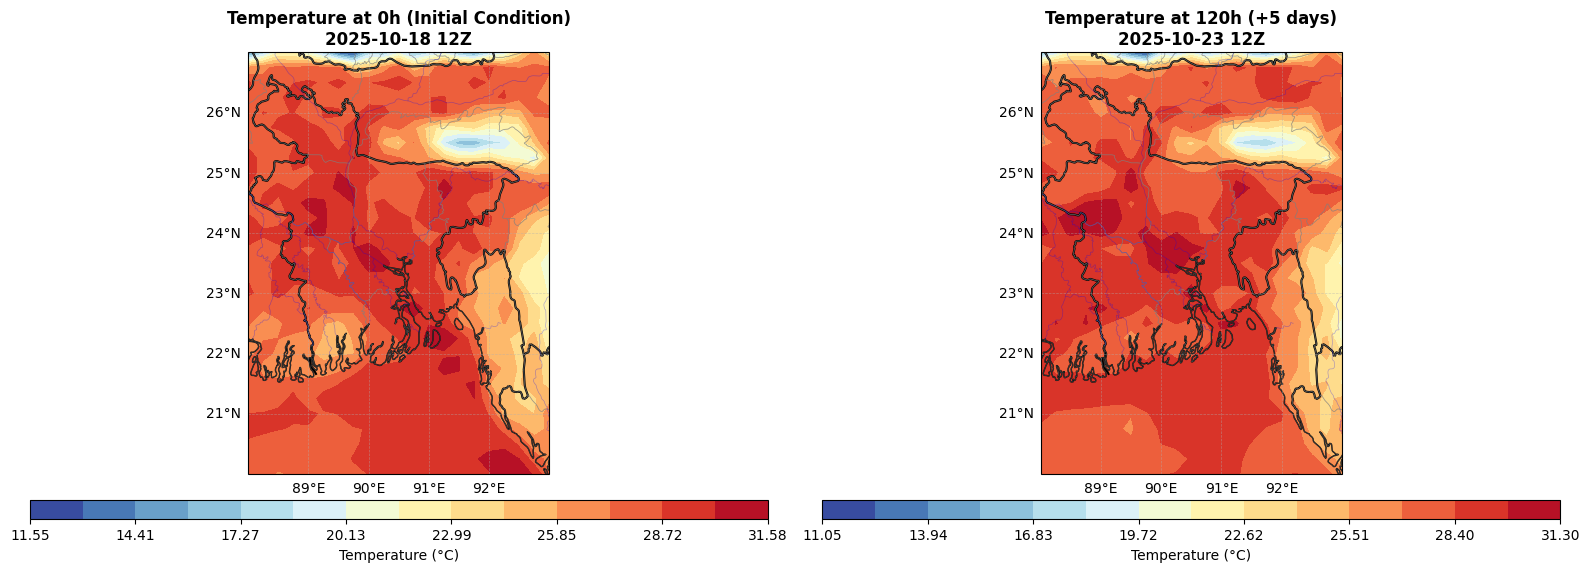


Time series at center point (24°N, 90.5°E):
  Nearest grid point: 24.00°N, 90.50°E
✅ Time series plot saved as 'temperature_timeseries.png'


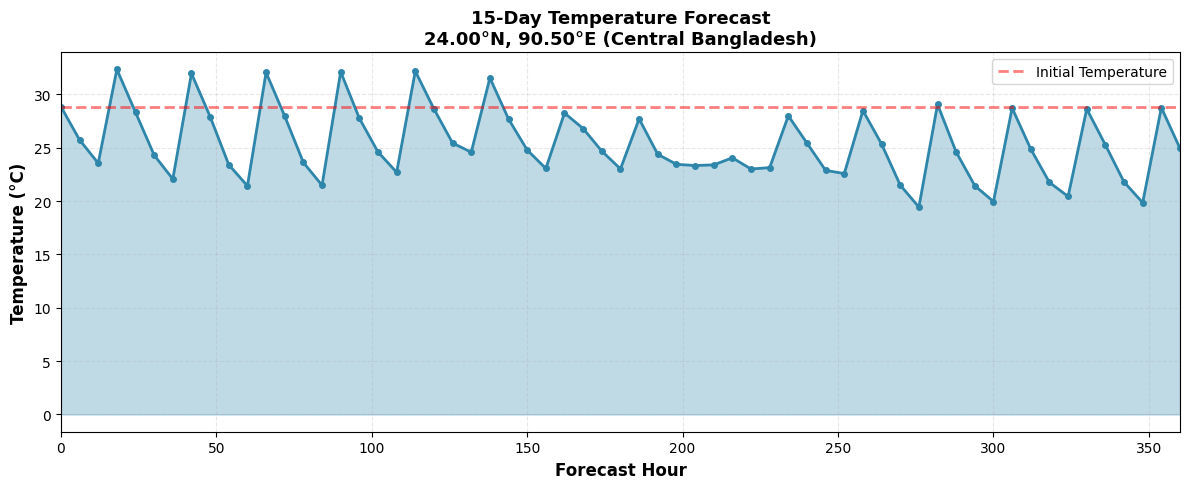


Loading multiple ensemble members for comparison...
✅ Ensemble spread plot saved as 'ensemble_spread.png'


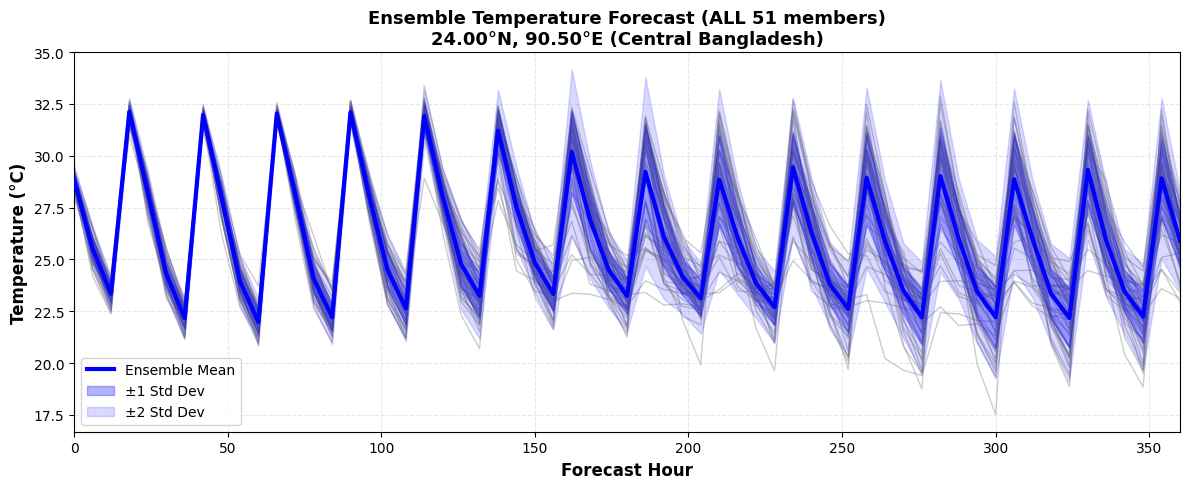


Creating detailed map with cities...
✅ Detailed map saved as 'bangladesh_detailed_map.png'


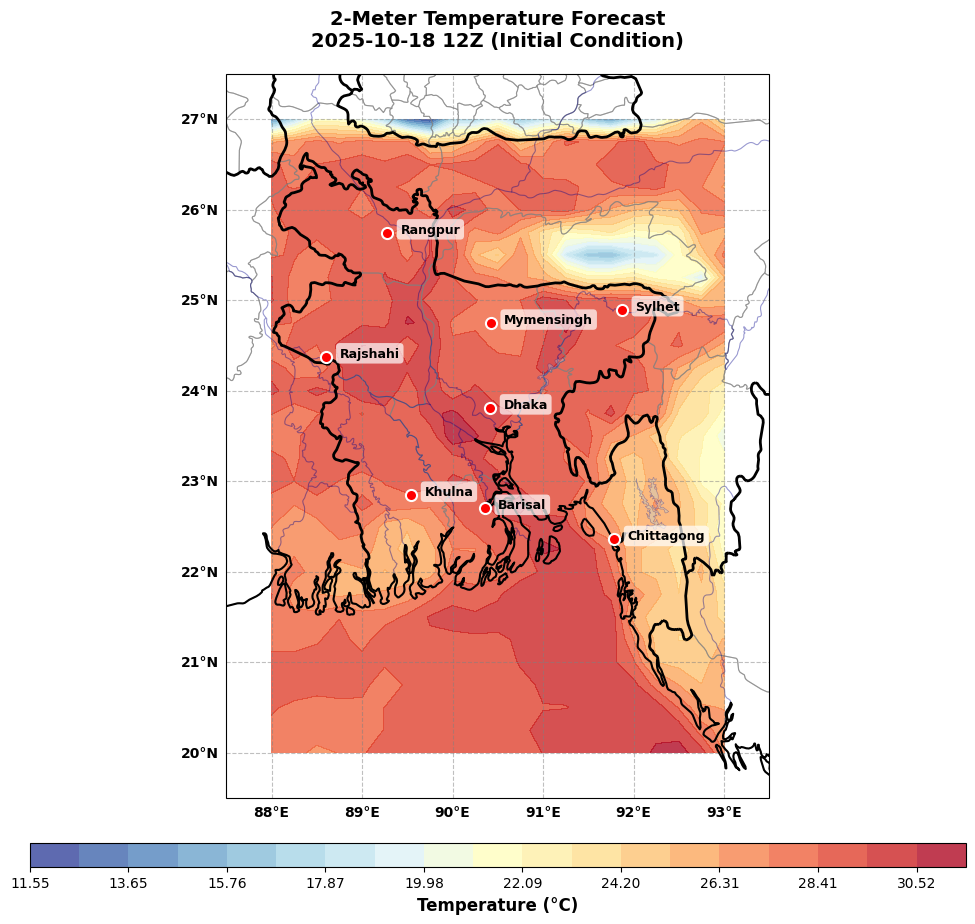


Summary Statistics:
  Total ensemble members available: 51
  Forecast range: 0h to 360h (61 time steps)
  Spatial coverage: 29 x 21 grid points
  Initial temperature: 28.9°C
  Final forecast temperature: 24.9°C
  Temperature change: -3.9°C
  Ensemble spread (at day 15): ±1.21°C


In [26]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

# Path to your data
data_dir = Path('data/ens/20251018_12z_2t')

# Load one ensemble member
nc_file = data_dir / '20251018_12z_2t_EN00.nc'
print(f"Reading: {nc_file.name}\n")

ds = xr.open_dataset(nc_file)
print("Dataset structure:")
print(ds)
print("\n" + "="*60)

# Get the variable name
var_name = list(ds.data_vars)[0]
print(f"Variable: {var_name}")
print(f"Dimensions: {ds[var_name].dims}")
print(f"Shape: {ds[var_name].shape}")

# Get coordinate info
print(f"\nCoordinates:")
print(f"  Steps: {len(ds.step)} (0h to {ds.step[-1].values})")
print(f"  Latitude: {ds.latitude.min().values:.2f}° to {ds.latitude.max().values:.2f}°")
print(f"  Longitude: {ds.longitude.min().values:.2f}° to {ds.longitude.max().values:.2f}°")
print(f"  Grid size: {len(ds.latitude)} x {len(ds.longitude)} = {len(ds.latitude) * len(ds.longitude)} points")

# Get data for first time step (using 'step' dimension)
print(f"\n" + "="*60)
print("Extracting first forecast step (0h)...")
data_first = ds[var_name].isel(step=0).values
print(f"  Shape: {data_first.shape}")
print(f"  Min: {np.nanmin(data_first):.2f} K = {np.nanmin(data_first) - 273.15:.2f}°C")
print(f"  Max: {np.nanmax(data_first):.2f} K = {np.nanmax(data_first) - 273.15:.2f}°C")
print(f"  Mean: {np.nanmean(data_first):.2f} K = {np.nanmean(data_first) - 273.15:.2f}°C")

# Create figure with Cartopy
fig = plt.figure(figsize=(16, 6))

# Define projection
projection = ccrs.PlateCarree()

# Plot 1: First time step (0h forecast)
ax1 = plt.subplot(1, 2, 1, projection=projection)
data_0h = ds[var_name].isel(step=0).values - 273.15  # Convert to Celsius

# Create contour plot
levels = np.linspace(data_0h.min(), data_0h.max(), 15)
im1 = ax1.contourf(ds.longitude, ds.latitude, data_0h,
                   levels=levels, cmap='RdYlBu_r', transform=projection)

# Add map features
ax1.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='black')
ax1.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax1.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.3)

# Add gridlines
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

ax1.set_extent([ds.longitude.min(), ds.longitude.max(),
                ds.latitude.min(), ds.latitude.max()], crs=projection)
ax1.set_title('Temperature at 0h (Initial Condition)\n2025-10-18 12Z',
              fontsize=12, fontweight='bold')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05, aspect=40)
cbar1.set_label('Temperature (°C)', fontsize=10)

# Plot 2: 5-day forecast (120h)
ax2 = plt.subplot(1, 2, 2, projection=projection)

step_120h = np.where(ds.step == np.timedelta64(120, 'h'))[0]
if len(step_120h) > 0:
    data_120h = ds[var_name].isel(step=step_120h[0]).values - 273.15
    title_str = 'Temperature at 120h (+5 days)\n2025-10-23 12Z'
else:
    # If 120h not found, use last available step
    data_120h = ds[var_name].isel(step=-1).values - 273.15
    hours = int(ds.step[-1].values / np.timedelta64(1, 'h'))
    title_str = f'Temperature at {hours}h forecast'

levels2 = np.linspace(data_120h.min(), data_120h.max(), 15)
im2 = ax2.contourf(ds.longitude, ds.latitude, data_120h,
                   levels=levels2, cmap='RdYlBu_r', transform=projection)

# Add map features
ax2.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='black')
ax2.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax2.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', alpha=0.5)
ax2.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.3)

# Add gridlines
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

ax2.set_extent([ds.longitude.min(), ds.longitude.max(),
                ds.latitude.min(), ds.latitude.max()], crs=projection)
ax2.set_title(title_str, fontsize=12, fontweight='bold')

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.05, aspect=40)
cbar2.set_label('Temperature (°C)', fontsize=10)

plt.tight_layout()
plt.savefig('bangladesh_temperature_forecast.png', dpi=150, bbox_inches='tight')
print(f"\n✅ Plot saved as 'bangladesh_temperature_forecast.png'")
plt.show()

# Time series at a specific location (approximate center of Bangladesh)
print(f"\n" + "="*60)
print("Time series at center point (24°N, 90.5°E):")

# Find nearest point
lat_target, lon_target = 24.0, 90.5
lat_idx = np.argmin(np.abs(ds.latitude.values - lat_target))
lon_idx = np.argmin(np.abs(ds.longitude.values - lon_target))

print(f"  Nearest grid point: {ds.latitude.values[lat_idx]:.2f}°N, {ds.longitude.values[lon_idx]:.2f}°E")

# Extract time series
temp_series = ds[var_name].isel(latitude=lat_idx, longitude=lon_idx).values - 273.15

# Plot time series
fig, ax = plt.subplots(figsize=(12, 5))
hours = [int(s / np.timedelta64(1, 'h')) for s in ds.step.values]
ax.plot(hours, temp_series, 'o-', linewidth=2, markersize=4, color='#2E86AB')
ax.fill_between(hours, temp_series, alpha=0.3, color='#2E86AB')
ax.set_xlabel('Forecast Hour', fontsize=12, fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_title(f'15-Day Temperature Forecast\n{ds.latitude.values[lat_idx]:.2f}°N, {ds.longitude.values[lon_idx]:.2f}°E (Central Bangladesh)',
          fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=temp_series[0], color='r', linestyle='--', alpha=0.5, linewidth=2, label='Initial Temperature')
ax.legend(fontsize=10)
ax.set_xlim(hours[0], hours[-1])
plt.tight_layout()
plt.savefig('temperature_timeseries.png', dpi=150, bbox_inches='tight')
print(f"✅ Time series plot saved as 'temperature_timeseries.png'")
plt.show()

# Load and compare multiple ensemble members
print(f"\n" + "="*60)
print("Loading multiple ensemble members for comparison...")

ensemble_files = sorted(data_dir.glob('20251018_12z_2t_EN*.nc'))[:51]  # First 10 ensembles
ensemble_data = []

for ens_file in ensemble_files:
    ds_ens = xr.open_dataset(ens_file)
    temp_series_ens = ds_ens[var_name].isel(latitude=lat_idx, longitude=lon_idx).values - 273.15
    ensemble_data.append(temp_series_ens)
    ds_ens.close()

ensemble_data = np.array(ensemble_data)

# Plot ensemble spread
fig, ax = plt.subplots(figsize=(12, 5))
hours = [int(s / np.timedelta64(1, 'h')) for s in ds.step.values]

# Plot individual ensemble members
for i, ens_series in enumerate(ensemble_data):
    ax.plot(hours, ens_series, alpha=0.4, linewidth=1, color='gray', zorder=1)

# Plot ensemble mean and spread
ens_mean = ensemble_data.mean(axis=0)
ens_std = ensemble_data.std(axis=0)

ax.plot(hours, ens_mean, 'b-', linewidth=3, label='Ensemble Mean', zorder=3)
ax.fill_between(hours, ens_mean - ens_std, ens_mean + ens_std,
                 alpha=0.3, color='blue', label='±1 Std Dev', zorder=2)
ax.fill_between(hours, ens_mean - 2*ens_std, ens_mean + 2*ens_std,
                 alpha=0.15, color='blue', label='±2 Std Dev', zorder=2)

ax.set_xlabel('Forecast Hour', fontsize=12, fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_title(f'Ensemble Temperature Forecast (ALL 51 members)\n{ds.latitude.values[lat_idx]:.2f}°N, {ds.longitude.values[lon_idx]:.2f}°E (Central Bangladesh)',
          fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='best')
ax.set_xlim(hours[0], hours[-1])
plt.tight_layout()
plt.savefig('ensemble_spread.png', dpi=150, bbox_inches='tight')
print(f"✅ Ensemble spread plot saved as 'ensemble_spread.png'")
plt.show()

# Create a detailed map with major cities
print(f"\n" + "="*60)
print("Creating detailed map with cities...")

fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=projection)

# Plot temperature data
data_plot = ds[var_name].isel(step=0).values - 273.15
levels = np.linspace(data_plot.min(), data_plot.max(), 20)
im = ax.contourf(ds.longitude, ds.latitude, data_plot,
                 levels=levels, cmap='RdYlBu_r', transform=projection, alpha=0.8)

# Add map features with better styling
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='black', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor='black', zorder=3)
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray', alpha=0.6, zorder=2)
ax.add_feature(cfeature.RIVERS, linewidth=0.8, edgecolor='darkblue', alpha=0.4, zorder=2)
ax.add_feature(cfeature.LAKES, linewidth=0.5, edgecolor='darkblue',
               facecolor='lightblue', alpha=0.3, zorder=2)

# Add major cities of Bangladesh
cities = {
    'Dhaka': (23.8103, 90.4125),
    'Chittagong': (22.3569, 91.7832),
    'Khulna': (22.8456, 89.5403),
    'Rajshahi': (24.3745, 88.6042),
    'Sylhet': (24.8949, 91.8687),
    'Barisal': (22.7010, 90.3535),
    'Rangpur': (25.7439, 89.2752),
    'Mymensingh': (24.7471, 90.4203)
}

for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'o', color='red', markersize=8,
            markeredgecolor='white', markeredgewidth=1.5,
            transform=projection, zorder=4)
    ax.text(lon + 0.15, lat, city, fontsize=9, fontweight='bold',
            transform=projection, zorder=5,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                     edgecolor='none', alpha=0.7))

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.8, alpha=0.5,
                  linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'weight': 'bold'}
gl.ylabel_style = {'size': 10, 'weight': 'bold'}

ax.set_extent([ds.longitude.min() - 0.5, ds.longitude.max() + 0.5,
                ds.latitude.min() - 0.5, ds.latitude.max() + 0.5], crs=projection)
ax.set_title('2-Meter Temperature Forecast\n2025-10-18 12Z (Initial Condition)',
              fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal',
                    pad=0.05, aspect=40, shrink=0.8)
cbar.set_label('Temperature (°C)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('bangladesh_detailed_map.png', dpi=200, bbox_inches='tight')
print(f"✅ Detailed map saved as 'bangladesh_detailed_map.png'")
plt.show()

print(f"\n" + "="*60)
print("Summary Statistics:")
print(f"  Total ensemble members available: {len(list(data_dir.glob('*.nc')))}")
print(f"  Forecast range: {hours[0]}h to {hours[-1]}h ({len(hours)} time steps)")
print(f"  Spatial coverage: {len(ds.latitude)} x {len(ds.longitude)} grid points")
print(f"  Initial temperature: {temp_series[0]:.1f}°C")
print(f"  Final forecast temperature: {temp_series[-1]:.1f}°C")
print(f"  Temperature change: {temp_series[-1] - temp_series[0]:+.1f}°C")
print(f"  Ensemble spread (at day 15): ±{ens_std[-1]:.2f}°C")
print("="*60)

ds.close()

##HRES

In [22]:
#!/usr/bin/env python
# ============================================================
# ECMWF Open Data IFS HRES Downloader (Deterministic)
# Python/Asyncio Version - FIXED FOR GOOGLE COLAB
# ============================================================

import asyncio
import aiohttp
import aiofiles
import json
import os
import sys
import time
import shutil
import xarray as xr
from pathlib import Path
from glob import glob
from tqdm.asyncio import tqdm as async_tqdm
from tqdm import tqdm as sync_tqdm

# FIXED for Google Colab: Allow nested event loops
try:
    import nest_asyncio
    nest_asyncio.apply()
except ImportError:
    pass

# --- Configuration ---
CLIP_BOX = {'lat_min': 20, 'lat_max': 27, 'lon_min': 88, 'lon_max': 93}

# ============================================================
# SET THESE VALUES FOR YOUR RUN
# ============================================================
DATE = "20251018"      # YYYYMMDD
TIME = "00z"           # 00z, 06z, 12z, 18z
VARIABLE = "2t"        # 2t, tp, msl, 10u, 10v, etc.
# ============================================================

async def download_index(session, step, index_dir, base_url, date):
    """Downloads a single index file."""
    filename = f"{date}000000-{step}h-oper-fc.index"
    url = f"{base_url}/{filename}"
    out_path = index_dir / filename

    if out_path.exists() and out_path.stat().st_size > 0:
        try:
            async with aiofiles.open(out_path, 'r') as f:
                first_line = await f.readline()
                if '"param"' in first_line:
                    return (True, f"✅ Skipped {step}h (already exists)")
        except Exception:
            pass

    try:
        async with session.get(url) as response:
            response.raise_for_status()
            content = await response.text()

            if '"param"' not in content:
                return (False, f"⚠️ Invalid (non-JSON) file for step {step}h")

            async with aiofiles.open(out_path, 'w') as f:
                await f.write(content)
            return (True, f"✅ {step}h")
    except aiohttp.ClientError as e:
        return (False, f"❌ Failed to download step {step}h: {str(e)[:50]}")

async def step1_download_all_indices(index_dir, base_url, date, steps):
    """Downloads all index files in parallel."""
    print(f"\n📥 [Step 1] Downloading all {len(steps)} index files...")
    tasks = []

    async with aiohttp.ClientSession() as session:
        for step in steps:
            tasks.append(download_index(session, step, index_dir, base_url, date))

        results = []
        failures = []
        for f in async_tqdm.as_completed(tasks, total=len(tasks), desc="Downloading Indices"):
            success, msg = await f
            results.append(msg)
            if not success:
                failures.append(msg)

    if failures:
        print(f"\n⚠️ Warning: {len(failures)} index downloads failed")

    print("✅ Index download complete!")
    return len(results) - len(failures)

def step2_create_grib_links(index_dir, link_file, base_url, date):
    """Creates a file with GRIB2 download links."""
    print(f"\n🔗 [Step 2] Creating GRIB2 links list...")

    links = []
    index_files = sorted(index_dir.glob("*.index"))

    for index_file in index_files:
        if index_file.stat().st_size > 0:
            # Extract step from filename
            step = index_file.stem.split('-')[1].replace('h', '')
            grib_filename = f"{date}000000-{step}h-oper-fc.grib2"
            links.append(f"{base_url}/{grib_filename}")

    with open(link_file, 'w') as f:
        f.write('\n'.join(links))

    print(f"📄 GRIB2 links saved: {link_file}")
    return links

def step3_parse_indices_and_create_jobs(index_dir, tmp_dir, base_url, date, variable):
    """Collects all variable records from index files."""
    print(f"\n🔍 [Step 3] Gathering {variable} records...")

    download_jobs = []

    index_files = list(index_dir.glob("*.index"))
    if not index_files:
        print("❌ No valid index files found. Aborting.")
        return []

    all_records = []
    for index_file in index_files:
        with open(index_file, 'r') as f:
            for line in f:
                if f'"param": "{variable}"' in line:
                    try:
                        record = json.loads(line)
                        all_records.append(record)
                    except json.JSONDecodeError:
                        pass

    if not all_records:
        print(f"❌ No {variable} records found in index files")
        return []

    # Save all records to a JSON file (for reference)
    records_file = tmp_dir / f"{variable}_records_all.json"
    with open(records_file, 'w') as f:
        json.dump(all_records, f, indent=2)

    print(f"✅ Found {len(all_records)} {variable} records across all indices")

    # Create download jobs
    for record in all_records:
        step_val = int(record["step"])
        offset = int(record["_offset"])
        length = int(record["_length"])

        # Construct GRIB URL from step
        grib_filename = f"{date}000000-{step_val}h-oper-fc.grib2"
        grib_url = f"{base_url}/{grib_filename}"

        download_jobs.append((grib_url, offset, length, step_val))

    return download_jobs

async def download_grib_slice(session, job, var_dir, variable):
    """Downloads a single GRIB slice using byte-range request."""
    grib_url, offset, length, step = job

    out_path = var_dir / f"{variable}_{step}h.grib2"

    if out_path.exists() and out_path.stat().st_size == length:
        return (True, f"✅ Skipping step {step}h")

    end = offset + length - 1
    headers = {'Range': f'bytes={offset}-{end}'}

    try:
        async with session.get(grib_url, headers=headers) as response:
            response.raise_for_status()
            content = await response.read()
            async with aiofiles.open(out_path, 'wb') as f:
                await f.write(content)
            return (True, f"✅ step {step}h")
    except Exception as e:
        return (False, f"❌ Failed step {step}h: {str(e)[:50]}")

async def step4_download_all_gribs(download_jobs, var_dir, variable):
    """Downloads all GRIB slices in parallel."""
    print(f"\n🚀 [Step 4] Extracting {variable} GRIB slices...")

    var_dir.mkdir(exist_ok=True)
    tasks = []

    timeout = aiohttp.ClientTimeout(total=300)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        for job in download_jobs:
            tasks.append(download_grib_slice(session, job, var_dir, variable))

        results = []
        failures = []
        for f in async_tqdm.as_completed(tasks, total=len(tasks), desc=f"Downloading {variable} GRIBs"):
            success, msg = await f
            results.append(msg)
            if not success:
                failures.append(msg)

    if failures:
        print(f"\n⚠️ Warning: {len(failures)} downloads failed")
        for fail in failures[:5]:
            print(f"   {fail}")

    print(f"✅ All {variable} ensemble GRIBs extracted! ({len(results) - len(failures)}/{len(results)} successful)")
    return len(failures) == 0

def get_step_from_path(grib_file_path):
    """Helper to sort GRIB files numerically by step."""
    try:
        step_str = Path(grib_file_path).stem.split('_')[-1].replace('h', '')
        return int(step_str)
    except Exception:
        return -1

def step5_merge_and_clip(var_dir, out_dir, date, time, variable, clip_box):
    """Merges all timesteps and clips to region (single deterministic forecast)."""
    print(f"\n🌀 [Step 5] Merging & clipping {variable}...")

    out_file = out_dir / f"{date}_{time}_{variable}.nc"
    temp_file = out_dir / f"tmp_{variable}.nc"

    # Find all GRIB files and sort by step
    grib_files_unsorted = glob(str(var_dir / "*.grib2"))
    if not grib_files_unsorted:
        print("⚠️ No GRIB files found!")
        return False

    grib_files = sorted(grib_files_unsorted, key=get_step_from_path)
    print(f"   Found {len(grib_files)} GRIB files to merge")

    try:
        # Open all GRIB files
        ds_list = []
        actual_var_name = None

        print("   Reading GRIB files...")
        for grib_file in sync_tqdm(grib_files, desc="Reading GRIBs"):
            try:
                ds = xr.open_dataset(
                    grib_file,
                    engine='cfgrib',
                    backend_kwargs={'indexpath': ''}
                )

                # Find the actual variable name
                data_vars = [v for v in ds.data_vars if v not in ['latitude', 'longitude', 'time', 'step', 'valid_time']]
                if data_vars and actual_var_name is None:
                    actual_var_name = data_vars[0]

                ds_list.append(ds)
            except Exception as e:
                print(f"   ⚠️ Could not read {Path(grib_file).name}: {str(e)[:40]}")
                continue

        if not ds_list:
            print("❌ Could not read any GRIB files")
            return False

        print(f"   Successfully read {len(ds_list)} GRIB files")
        print("   Merging along time dimension...")

        # Merge datasets
        try:
            ds = xr.concat(ds_list, dim='step', coords='minimal', compat='override')
        except Exception:
            ds = xr.concat(ds_list, dim='time', coords='minimal', compat='override')

        print(f"   Merged dataset shape: {ds[actual_var_name].shape if actual_var_name else 'unknown'}")

        # Clip to region
        print("   Clipping to Bangladesh region...")
        try:
            lat_name = 'latitude' if 'latitude' in ds.dims else ('lat' if 'lat' in ds.dims else None)
            lon_name = 'longitude' if 'longitude' in ds.dims else ('lon' if 'lon' in ds.dims else None)

            if lat_name and lon_name:
                ds_clipped = ds.sel(
                    {lat_name: slice(clip_box['lat_max'], clip_box['lat_min']),
                     lon_name: slice(clip_box['lon_min'], clip_box['lon_max'])}
                )
                print(f"   Clipped to: {len(ds_clipped[lat_name])} x {len(ds_clipped[lon_name])} grid points")
            else:
                print("   ⚠️ Could not find lat/lon coordinates, saving full domain")
                ds_clipped = ds
        except Exception as e:
            print(f"   ⚠️ Clipping failed ({str(e)[:30]}), saving full domain")
            ds_clipped = ds

        # Save to NetCDF with compression
        print(f"   Saving to {out_file.name}...")
        if actual_var_name:
            encoding = {
                actual_var_name: {
                    'zlib': True,
                    'complevel': 4,
                    'dtype': 'float32'
                }
            }
        else:
            encoding = {}

        # Write to temp file first
        ds_clipped.to_netcdf(temp_file, encoding=encoding, format='NETCDF4')

        # Move to final location
        if temp_file.exists():
            if out_file.exists():
                out_file.unlink()
            temp_file.rename(out_file)

        # Close datasets
        for ds_item in ds_list:
            ds_item.close()
        ds_clipped.close()

        # Verify output
        if out_file.exists() and out_file.stat().st_size > 1000:
            file_size = out_file.stat().st_size / 1e6
            print(f"✅ Merged and clipped → {out_file.name} ({file_size:.2f} MB)")
            return True
        else:
            print("❌ Output file created but is empty or too small")
            return False

    except Exception as e:
        print(f"❌ Merge failed: {str(e)}")
        if temp_file.exists():
            temp_file.unlink()
        return False

def step6_cleanup(index_dir, var_dir, tmp_dir, link_file):
    """Clean up temporary files."""
    print("\n🧹 [Step 6] Cleaning up temporary files...")
    try:
        if index_dir.exists():
            shutil.rmtree(index_dir)
        if var_dir.exists():
            shutil.rmtree(var_dir)
        if tmp_dir.exists():
            shutil.rmtree(tmp_dir)
        if link_file.exists():
            link_file.unlink()
        print("✅ Cleanup complete.")
    except OSError as e:
        print(f"⚠️ Warning: Could not remove temp directories: {e}")

async def main():
    steps = range(0, 361, 6)

    BASE_URL = f"https://storage.googleapis.com/ecmwf-open-data/{DATE}/{TIME}/ifs/0p25/oper"

    MAIN_DIR = Path(f"data/hres/{DATE}_{TIME}_{VARIABLE}")
    INDEX_DIR = MAIN_DIR / "index_files"
    VAR_DIR = MAIN_DIR / f"{VARIABLE}_data"
    TMP_DIR = MAIN_DIR / "tmp"
    OUT_DIR = MAIN_DIR
    LINK_FILE = MAIN_DIR / f"grib2_links_{DATE}_{TIME}.txt"

    INDEX_DIR.mkdir(parents=True, exist_ok=True)
    VAR_DIR.mkdir(parents=True, exist_ok=True)
    TMP_DIR.mkdir(parents=True, exist_ok=True)
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    print("============================================================")
    print(f" ECMWF Open Data IFS HRES Downloader (Deterministic)")
    print(f" DATE: {DATE} | TIME: {TIME} | VARIABLE: {VARIABLE}")
    print(f" Output Dir: {MAIN_DIR}")
    print("============================================================")

    start_time = time.time()

    # Step 1: Download indices
    success_count = await step1_download_all_indices(INDEX_DIR, BASE_URL, DATE, steps)
    if success_count == 0:
        print("❌ No index files downloaded successfully. Exiting.")
        return

    # Step 2: Create GRIB links file
    links = step2_create_grib_links(INDEX_DIR, LINK_FILE, BASE_URL, DATE)

    # Step 3: Parse indices and create download jobs
    download_jobs = step3_parse_indices_and_create_jobs(INDEX_DIR, TMP_DIR, BASE_URL, DATE, VARIABLE)
    if not download_jobs:
        print("❌ No download jobs found. Exiting.")
        return

    # Step 4: Download GRIB slices
    success = await step4_download_all_gribs(download_jobs, VAR_DIR, VARIABLE)
    if not success:
        print("\n⚠️ Warning: Some downloads failed, but continuing with processing...")

    # Step 5: Merge and clip
    merge_success = step5_merge_and_clip(VAR_DIR, OUT_DIR, DATE, TIME, VARIABLE, CLIP_BOX)

    if not merge_success:
        print("\n❌ ERROR: Failed to create final NetCDF file!")
        return

    # Step 6: Cleanup
    step6_cleanup(INDEX_DIR, VAR_DIR, TMP_DIR, LINK_FILE)

    # Final summary
    output_file = OUT_DIR / f"{DATE}_{TIME}_{VARIABLE}.nc"
    print("\n" + "="*60)
    if output_file.exists() and output_file.stat().st_size > 1000:
        print(f"🎯 Success! Final NetCDF file:")
        print(f"   {output_file}")
        print(f"   Size: {output_file.stat().st_size / 1e6:.2f} MB")

        # Quick verification
        try:
            ds = xr.open_dataset(output_file)
            print(f"\n   Dataset Info:")
            print(f"   Variables: {list(ds.data_vars)}")
            if 'step' in ds.dims:
                print(f"   Time steps: {len(ds.step)}")
            elif 'time' in ds.dims:
                print(f"   Time steps: {len(ds.time)}")
            if 'latitude' in ds.dims:
                print(f"   Lat range: {ds.latitude.min().values:.2f}° to {ds.latitude.max().values:.2f}°")
                print(f"   Lon range: {ds.longitude.min().values:.2f}° to {ds.longitude.max().values:.2f}°")
            ds.close()
        except Exception as e:
            print(f"   ⚠️ Could not read NetCDF: {str(e)[:50]}")
    else:
        print(f"❌ No valid NetCDF file was created!")

    print(f"\n   Total time: {time.time() - start_time:.2f} seconds")
    print("="*60)

if __name__ == "__main__":
    asyncio.run(main())

 ECMWF Open Data IFS HRES Downloader (Deterministic)
 DATE: 20251018 | TIME: 00z | VARIABLE: 2t
 Output Dir: data/hres/20251018_00z_2t

📥 [Step 1] Downloading all 61 index files...


✅ Index download complete!

🔗 [Step 2] Creating GRIB2 links list...
📄 GRIB2 links saved: data/hres/20251018_00z_2t/grib2_links_20251018_00z.txt

🔍 [Step 3] Gathering 2t records...
✅ Found 61 2t records across all indices

🚀 [Step 4] Extracting 2t GRIB slices...


✅ All 2t ensemble GRIBs extracted! (61/61 successful)

🌀 [Step 5] Merging & clipping 2t...
   Found 61 GRIB files to merge
   Reading GRIB files...


Reading GRIBs: 100%|██████████| 61/61 [00:01<00:00, 35.25it/s]


   Successfully read 61 GRIB files
   Merging along time dimension...
   Merged dataset shape: (61, 721, 1440)
   Clipping to Bangladesh region...
   Clipped to: 29 x 21 grid points
   Saving to 20251018_00z_2t.nc...
✅ Merged and clipped → 20251018_00z_2t.nc (0.10 MB)

🧹 [Step 6] Cleaning up temporary files...
✅ Cleanup complete.

🎯 Success! Final NetCDF file:
   data/hres/20251018_00z_2t/20251018_00z_2t.nc
   Size: 0.10 MB

   Dataset Info:
   Variables: ['t2m']
   Time steps: 61
   Lat range: 20.00° to 27.00°
   Lon range: 88.00° to 93.00°

   Total time: 9.24 seconds


Reading: 20251018_00z_2t.nc

Dataset structure:
<xarray.Dataset> Size: 150kB
Dimensions:            (step: 61, latitude: 29, longitude: 21)
Coordinates:
  * step               (step) timedelta64[ns] 488B 0 days 00:00:00 ... 15 day...
  * latitude           (latitude) float64 232B 27.0 26.75 26.5 ... 20.25 20.0
  * longitude          (longitude) float64 168B 88.0 88.25 88.5 ... 92.75 93.0
    time               datetime64[ns] 8B ...
    heightAboveGround  float64 8B ...
    valid_time         datetime64[ns] 8B ...
Data variables:
    t2m                (step, latitude, longitude) float32 149kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-19T07:07 GRIB to CDM+CF via cfgrib-0.9.1...

Variable: 

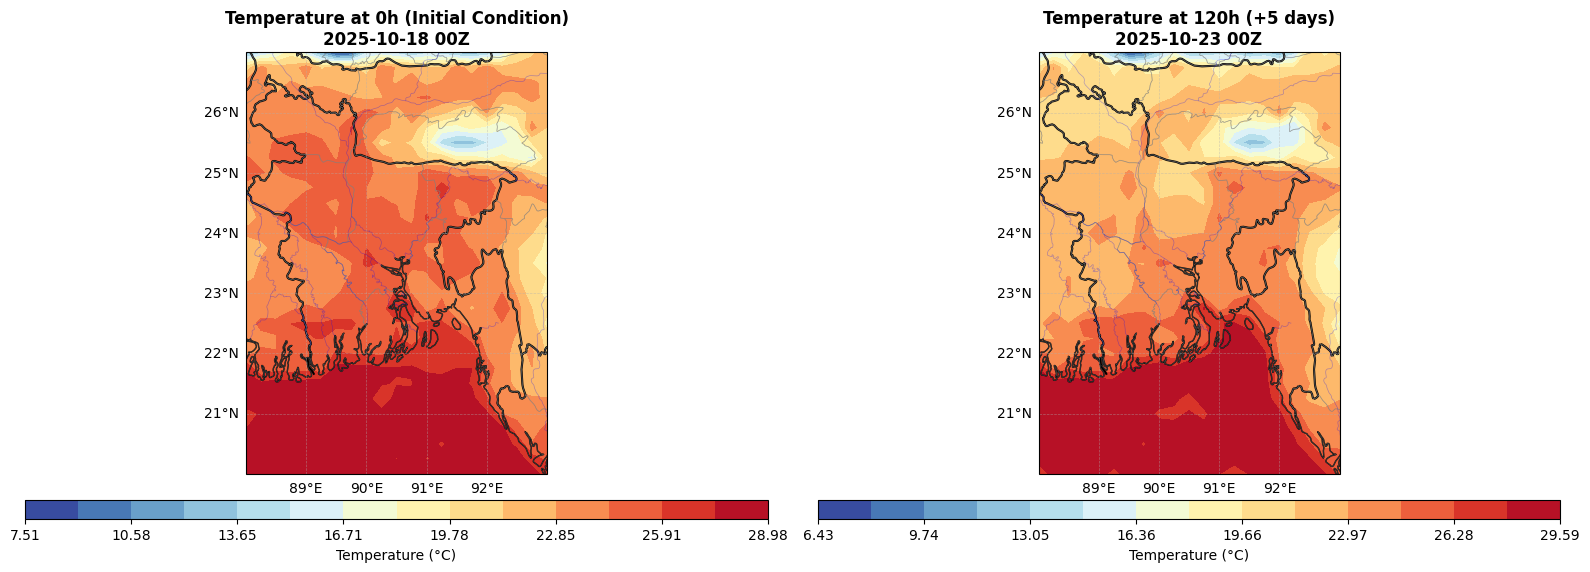


Creating time series plot...
  Location: 23.75°N, 90.50°E (Near Dhaka)
✅ Time series saved as 'hres_temperature_timeseries.png'


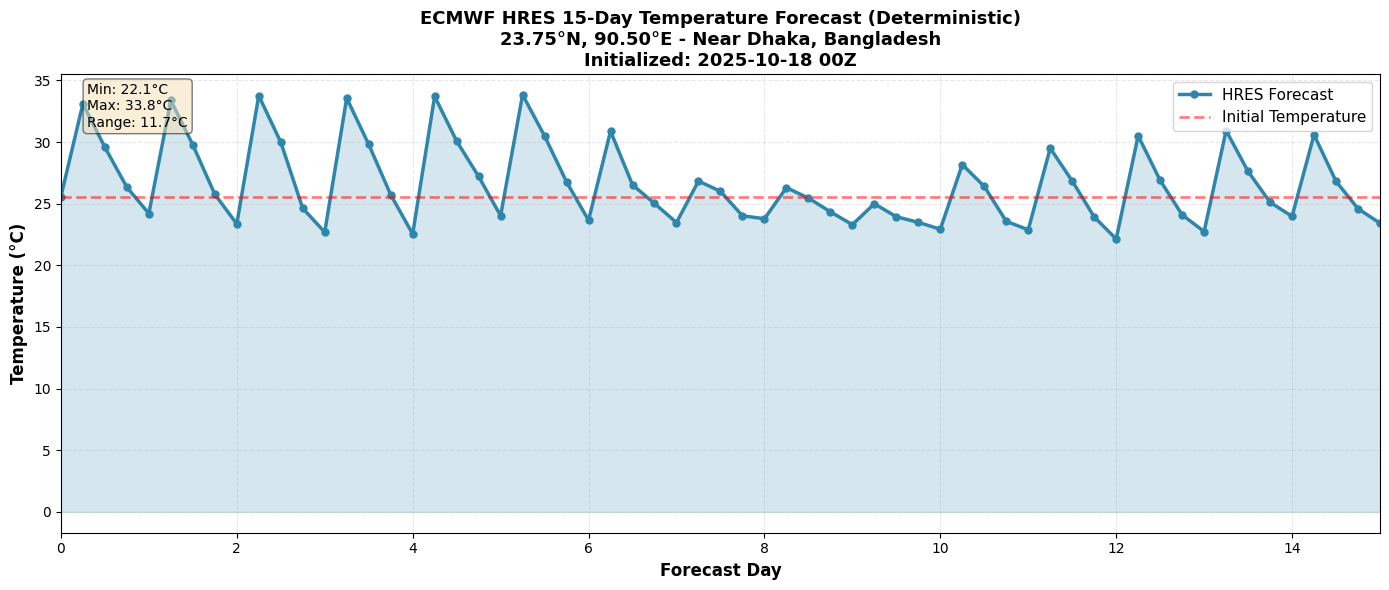


Creating detailed map with cities...
✅ Detailed map saved as 'hres_detailed_map.png'


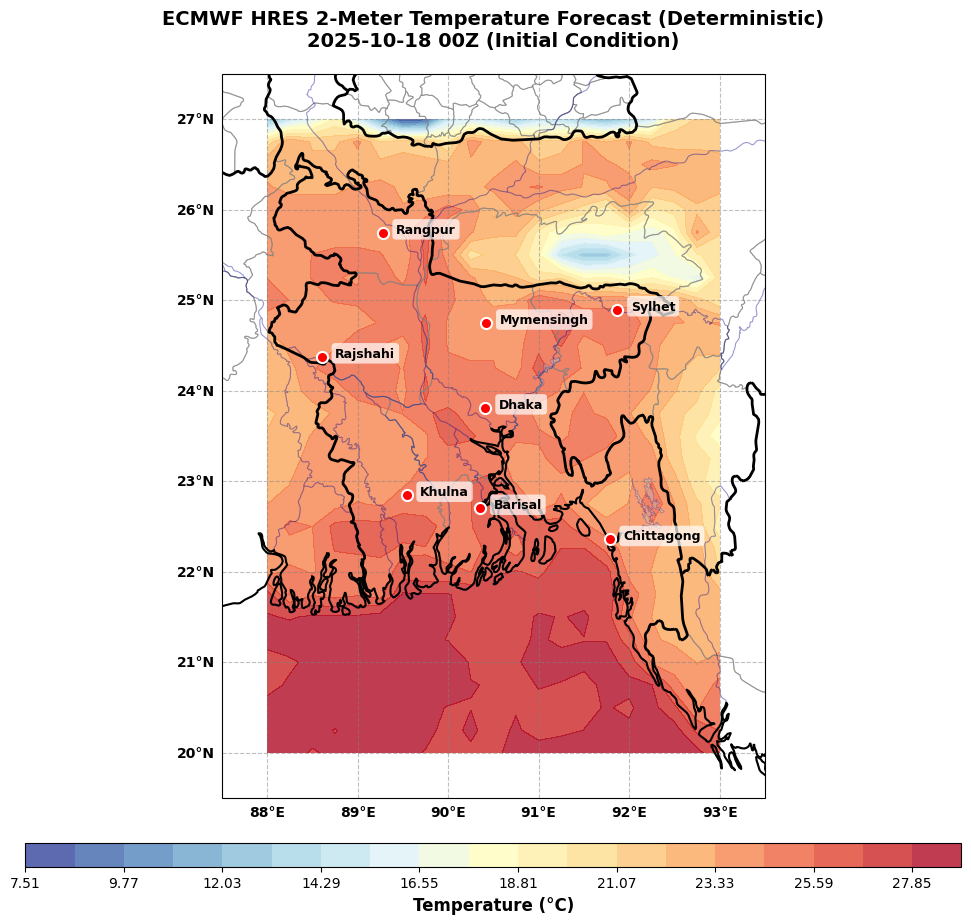


Creating multi-day forecast panels...
✅ Multi-day forecast saved as 'hres_multi_day_forecast.png'


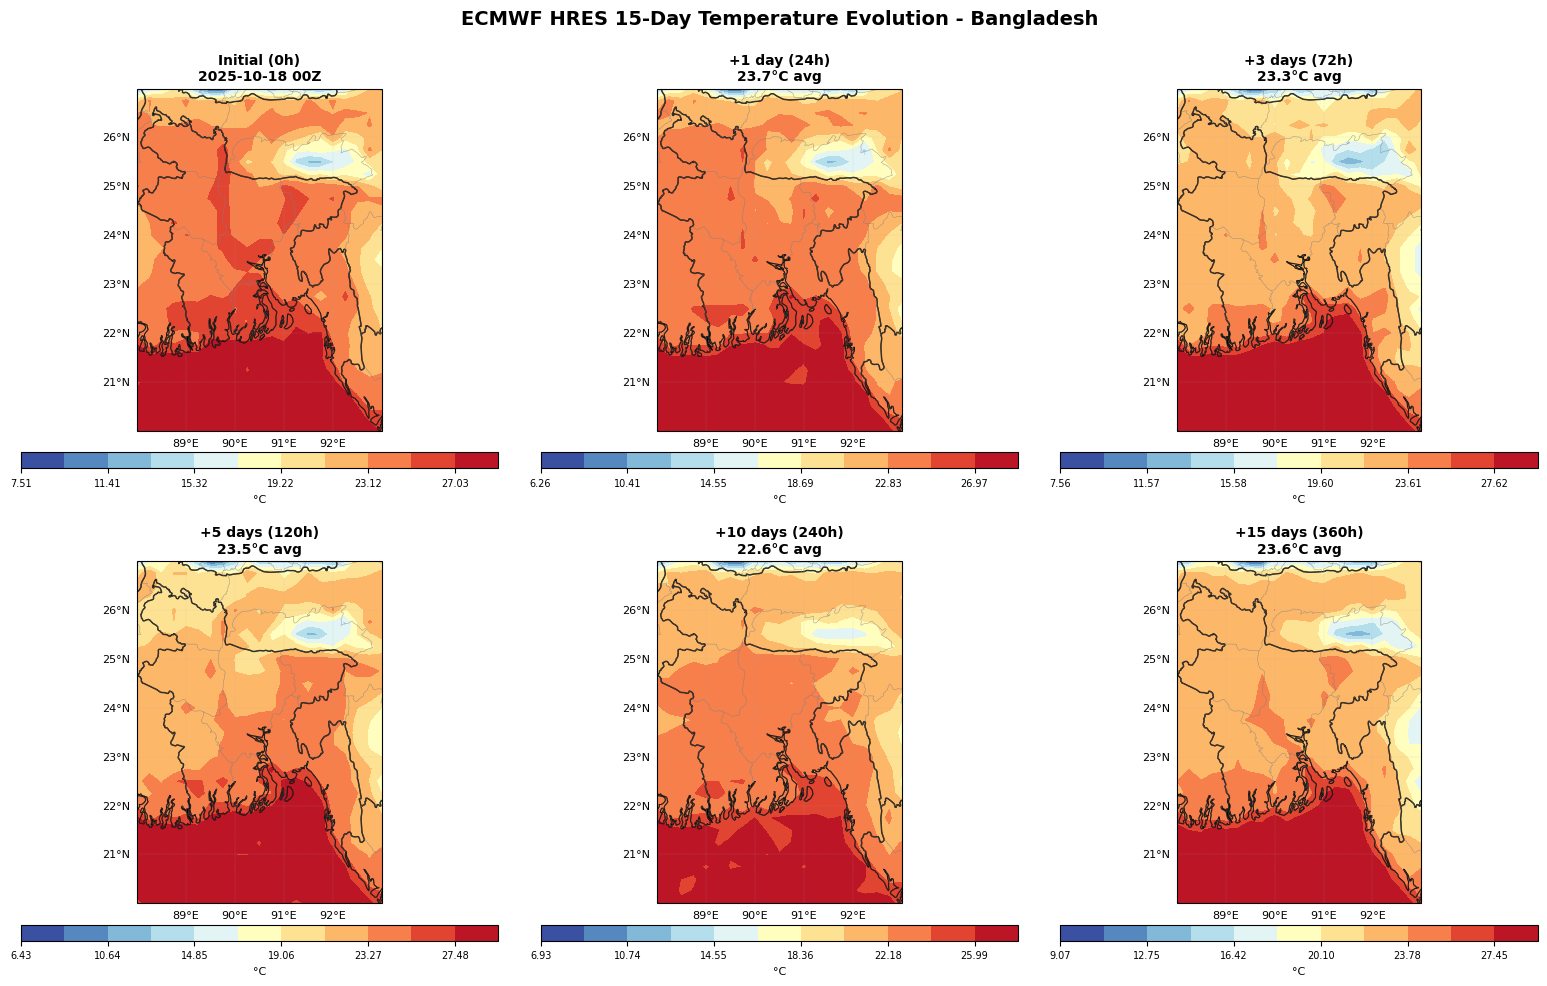


Summary Statistics:
  Forecast model: ECMWF HRES (Deterministic)
  Initialization: 2025-10-18 00Z
  Forecast range: 0h to 360h (61 time steps)
  Spatial coverage: 29 x 21 grid points
  Location analyzed: 23.75°N, 90.50°E
  Initial temperature: 25.6°C
  Final forecast temperature: 23.4°C
  Temperature change: -2.2°C
  Minimum temperature: 22.1°C (Day 12.0)
  Maximum temperature: 33.8°C (Day 5.2)


In [25]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

# Path to your HRES data
data_file = Path('data/hres/20251018_00z_2t/20251018_00z_2t.nc')

print(f"Reading: {data_file.name}\n")

ds = xr.open_dataset(data_file)
print("Dataset structure:")
print(ds)
print("\n" + "="*60)

# Get the variable name
var_name = list(ds.data_vars)[0]
print(f"Variable: {var_name}")
print(f"Dimensions: {ds[var_name].dims}")
print(f"Shape: {ds[var_name].shape}")

# Get coordinate info
print(f"\nCoordinates:")
print(f"  Steps: {len(ds.step)} (0h to {ds.step[-1].values})")
print(f"  Latitude: {ds.latitude.min().values:.2f}° to {ds.latitude.max().values:.2f}°")
print(f"  Longitude: {ds.longitude.min().values:.2f}° to {ds.longitude.max().values:.2f}°")
print(f"  Grid size: {len(ds.latitude)} x {len(ds.longitude)} = {len(ds.latitude) * len(ds.longitude)} points")

# Get data statistics
print(f"\n" + "="*60)
print("Extracting first forecast step (0h)...")
data_first = ds[var_name].isel(step=0).values
print(f"  Shape: {data_first.shape}")
print(f"  Min: {np.nanmin(data_first):.2f} K = {np.nanmin(data_first) - 273.15:.2f}°C")
print(f"  Max: {np.nanmax(data_first):.2f} K = {np.nanmax(data_first) - 273.15:.2f}°C")
print(f"  Mean: {np.nanmean(data_first):.2f} K = {np.nanmean(data_first) - 273.15:.2f}°C")

# ============================================================
# Plot 1: Side-by-side spatial maps
# ============================================================
print(f"\n" + "="*60)
print("Creating spatial comparison plots...")

fig = plt.figure(figsize=(16, 6))
projection = ccrs.PlateCarree()

# Plot 1: First time step (0h forecast)
ax1 = plt.subplot(1, 2, 1, projection=projection)
data_0h = ds[var_name].isel(step=0).values - 273.15  # Convert to Celsius

levels = np.linspace(data_0h.min(), data_0h.max(), 15)
im1 = ax1.contourf(ds.longitude, ds.latitude, data_0h,
                   levels=levels, cmap='RdYlBu_r', transform=projection)

# Add map features
ax1.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='black')
ax1.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax1.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.3)

# Add gridlines
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

ax1.set_extent([ds.longitude.min(), ds.longitude.max(),
                ds.latitude.min(), ds.latitude.max()], crs=projection)
ax1.set_title('Temperature at 0h (Initial Condition)\n2025-10-18 00Z',
              fontsize=12, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05, aspect=40)
cbar1.set_label('Temperature (°C)', fontsize=10)

# Plot 2: 5-day forecast (120h)
ax2 = plt.subplot(1, 2, 2, projection=projection)

step_120h = np.where(ds.step == np.timedelta64(120, 'h'))[0]
if len(step_120h) > 0:
    data_120h = ds[var_name].isel(step=step_120h[0]).values - 273.15
    title_str = 'Temperature at 120h (+5 days)\n2025-10-23 00Z'
else:
    data_120h = ds[var_name].isel(step=-1).values - 273.15
    hours = int(ds.step[-1].values / np.timedelta64(1, 'h'))
    title_str = f'Temperature at {hours}h forecast'

levels2 = np.linspace(data_120h.min(), data_120h.max(), 15)
im2 = ax2.contourf(ds.longitude, ds.latitude, data_120h,
                   levels=levels2, cmap='RdYlBu_r', transform=projection)

# Add map features
ax2.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='black')
ax2.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax2.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', alpha=0.5)
ax2.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue', alpha=0.3)

# Add gridlines
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

ax2.set_extent([ds.longitude.min(), ds.longitude.max(),
                ds.latitude.min(), ds.latitude.max()], crs=projection)
ax2.set_title(title_str, fontsize=12, fontweight='bold')

cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.05, aspect=40)
cbar2.set_label('Temperature (°C)', fontsize=10)

plt.tight_layout()
plt.savefig('hres_temperature_comparison.png', dpi=150, bbox_inches='tight')
print(f"✅ Spatial comparison saved as 'hres_temperature_comparison.png'")
plt.show()

# ============================================================
# Plot 2: Time series at a point
# ============================================================
print(f"\n" + "="*60)
print("Creating time series plot...")

# Find nearest point to Dhaka (23.8°N, 90.4°E)
lat_target, lon_target = 23.8, 90.4
lat_idx = np.argmin(np.abs(ds.latitude.values - lat_target))
lon_idx = np.argmin(np.abs(ds.longitude.values - lon_target))

print(f"  Location: {ds.latitude.values[lat_idx]:.2f}°N, {ds.longitude.values[lon_idx]:.2f}°E (Near Dhaka)")

# Extract time series
temp_series = ds[var_name].isel(latitude=lat_idx, longitude=lon_idx).values - 273.15

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
hours = [int(s / np.timedelta64(1, 'h')) for s in ds.step.values]
days = [h / 24 for h in hours]

ax.plot(days, temp_series, 'o-', linewidth=2.5, markersize=5, color='#2E86AB', label='HRES Forecast')
ax.fill_between(days, temp_series, alpha=0.2, color='#2E86AB')

ax.set_xlabel('Forecast Day', fontsize=12, fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_title(f'ECMWF HRES 15-Day Temperature Forecast (Deterministic)\n{ds.latitude.values[lat_idx]:.2f}°N, {ds.longitude.values[lon_idx]:.2f}°E - Near Dhaka, Bangladesh\nInitialized: 2025-10-18 00Z',
          fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=temp_series[0], color='r', linestyle='--', alpha=0.5, linewidth=2, label='Initial Temperature')

# Add temperature range annotation
ax.text(0.02, 0.98, f'Min: {temp_series.min():.1f}°C\nMax: {temp_series.max():.1f}°C\nRange: {temp_series.max() - temp_series.min():.1f}°C',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.legend(fontsize=11, loc='upper right')
ax.set_xlim(0, days[-1])
plt.tight_layout()
plt.savefig('hres_temperature_timeseries.png', dpi=150, bbox_inches='tight')
print(f"✅ Time series saved as 'hres_temperature_timeseries.png'")
plt.show()

# ============================================================
# Plot 3: Detailed map with cities
# ============================================================
print(f"\n" + "="*60)
print("Creating detailed map with cities...")

fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=projection)

# Plot temperature data
data_plot = ds[var_name].isel(step=0).values - 273.15
levels = np.linspace(data_plot.min(), data_plot.max(), 20)
im = ax.contourf(ds.longitude, ds.latitude, data_plot,
                 levels=levels, cmap='RdYlBu_r', transform=projection, alpha=0.8)

# Add map features
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='black', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor='black', zorder=3)
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray', alpha=0.6, zorder=2)
ax.add_feature(cfeature.RIVERS, linewidth=0.8, edgecolor='darkblue', alpha=0.4, zorder=2)
ax.add_feature(cfeature.LAKES, linewidth=0.5, edgecolor='darkblue',
               facecolor='lightblue', alpha=0.3, zorder=2)

# Add major cities
cities = {
    'Dhaka': (23.8103, 90.4125),
    'Chittagong': (22.3569, 91.7832),
    'Khulna': (22.8456, 89.5403),
    'Rajshahi': (24.3745, 88.6042),
    'Sylhet': (24.8949, 91.8687),
    'Barisal': (22.7010, 90.3535),
    'Rangpur': (25.7439, 89.2752),
    'Mymensingh': (24.7471, 90.4203)
}

for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, 'o', color='red', markersize=8,
            markeredgecolor='white', markeredgewidth=1.5,
            transform=projection, zorder=4)
    ax.text(lon + 0.15, lat, city, fontsize=9, fontweight='bold',
            transform=projection, zorder=5,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                     edgecolor='none', alpha=0.7))

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.8, alpha=0.5,
                  linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'weight': 'bold'}
gl.ylabel_style = {'size': 10, 'weight': 'bold'}

ax.set_extent([ds.longitude.min() - 0.5, ds.longitude.max() + 0.5,
                ds.latitude.min() - 0.5, ds.latitude.max() + 0.5], crs=projection)
ax.set_title('ECMWF HRES 2-Meter Temperature Forecast (Deterministic)\n2025-10-18 00Z (Initial Condition)',
              fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal',
                    pad=0.05, aspect=40, shrink=0.8)
cbar.set_label('Temperature (°C)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('hres_detailed_map.png', dpi=200, bbox_inches='tight')
print(f"✅ Detailed map saved as 'hres_detailed_map.png'")
plt.show()

# ============================================================
# Plot 4: Multi-day forecast panels
# ============================================================
print(f"\n" + "="*60)
print("Creating multi-day forecast panels...")

fig = plt.figure(figsize=(16, 10))
projection = ccrs.PlateCarree()

# Select 6 forecast times: 0h, 24h, 72h, 120h, 240h, 360h
forecast_hours = [0, 24, 72, 120, 240, 360]
forecast_indices = []

for fh in forecast_hours:
    step_idx = np.where(ds.step == np.timedelta64(fh, 'h'))[0]
    if len(step_idx) > 0:
        forecast_indices.append((fh, step_idx[0]))

for idx, (fh, step_idx) in enumerate(forecast_indices):
    ax = plt.subplot(2, 3, idx + 1, projection=projection)

    data = ds[var_name].isel(step=step_idx).values - 273.15
    levels = np.linspace(data.min(), data.max(), 12)
    im = ax.contourf(ds.longitude, ds.latitude, data,
                     levels=levels, cmap='RdYlBu_r', transform=projection)

    # Map features
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray', alpha=0.5)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    ax.set_extent([ds.longitude.min(), ds.longitude.max(),
                    ds.latitude.min(), ds.latitude.max()], crs=projection)

    # Title with forecast time
    days = fh // 24
    if days == 0:
        title = f'Initial (0h)\n2025-10-18 00Z'
    else:
        title = f'+{days} day{"s" if days > 1 else ""} ({fh}h)\n{data.mean():.1f}°C avg'
    ax.set_title(title, fontsize=10, fontweight='bold')

    # Colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, aspect=30, shrink=0.9)
    cbar.set_label('°C', fontsize=8)
    cbar.ax.tick_params(labelsize=7)

plt.suptitle('ECMWF HRES 15-Day Temperature Evolution - Bangladesh',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('hres_multi_day_forecast.png', dpi=150, bbox_inches='tight')
print(f"✅ Multi-day forecast saved as 'hres_multi_day_forecast.png'")
plt.show()

# ============================================================
# Summary Statistics
# ============================================================
print(f"\n" + "="*60)
print("Summary Statistics:")
print(f"  Forecast model: ECMWF HRES (Deterministic)")
print(f"  Initialization: 2025-10-18 00Z")
print(f"  Forecast range: {hours[0]}h to {hours[-1]}h ({len(hours)} time steps)")
print(f"  Spatial coverage: {len(ds.latitude)} x {len(ds.longitude)} grid points")
print(f"  Location analyzed: {ds.latitude.values[lat_idx]:.2f}°N, {ds.longitude.values[lon_idx]:.2f}°E")
print(f"  Initial temperature: {temp_series[0]:.1f}°C")
print(f"  Final forecast temperature: {temp_series[-1]:.1f}°C")
print(f"  Temperature change: {temp_series[-1] - temp_series[0]:+.1f}°C")

# Recreate days array for statistics
forecast_days = [h / 24 for h in hours]
min_idx = int(np.argmin(temp_series))
max_idx = int(np.argmax(temp_series))
print(f"  Minimum temperature: {temp_series.min():.1f}°C (Day {forecast_days[min_idx]:.1f})")
print(f"  Maximum temperature: {temp_series.max():.1f}°C (Day {forecast_days[max_idx]:.1f})")
print("="*60)

ds.close()